Trades: 758, Wins: 331, Losses: 427, Total PnL (price units): 4594004.74, Avg R: 0.30
       box_date          entry_time   side  entry_price         sl        tp  \
0    2024-08-02 2024-08-02 15:00:00  short     64426.17  64636.130  64006.25   
1    2024-08-03 2024-08-03 14:00:00  short     61878.75  62050.805  61534.64   
2    2024-08-04 2024-08-04 14:00:00  short     60751.40  60909.790  60434.62   
3    2024-08-05 2024-08-05 14:00:00   long     51582.57  50563.025  53621.66   
4    2024-08-06 2024-08-06 14:00:00   long     55557.79  55159.825  56353.72   
..          ...                 ...    ...          ...        ...       ...   
753  2025-12-11 2025-12-11 15:00:00  short     90015.73  90206.215  89634.76   
754  2025-12-12 2025-12-12 14:00:00   long     92446.71  92263.195  92813.74   
755  2025-12-12 2025-12-12 14:00:00  short     92079.68  92263.195  91712.65   
756  2025-12-13 2025-12-13 14:00:00  short     90293.24  90393.965  90091.79   
757  2025-12-14 2025-12-14 14:00:0

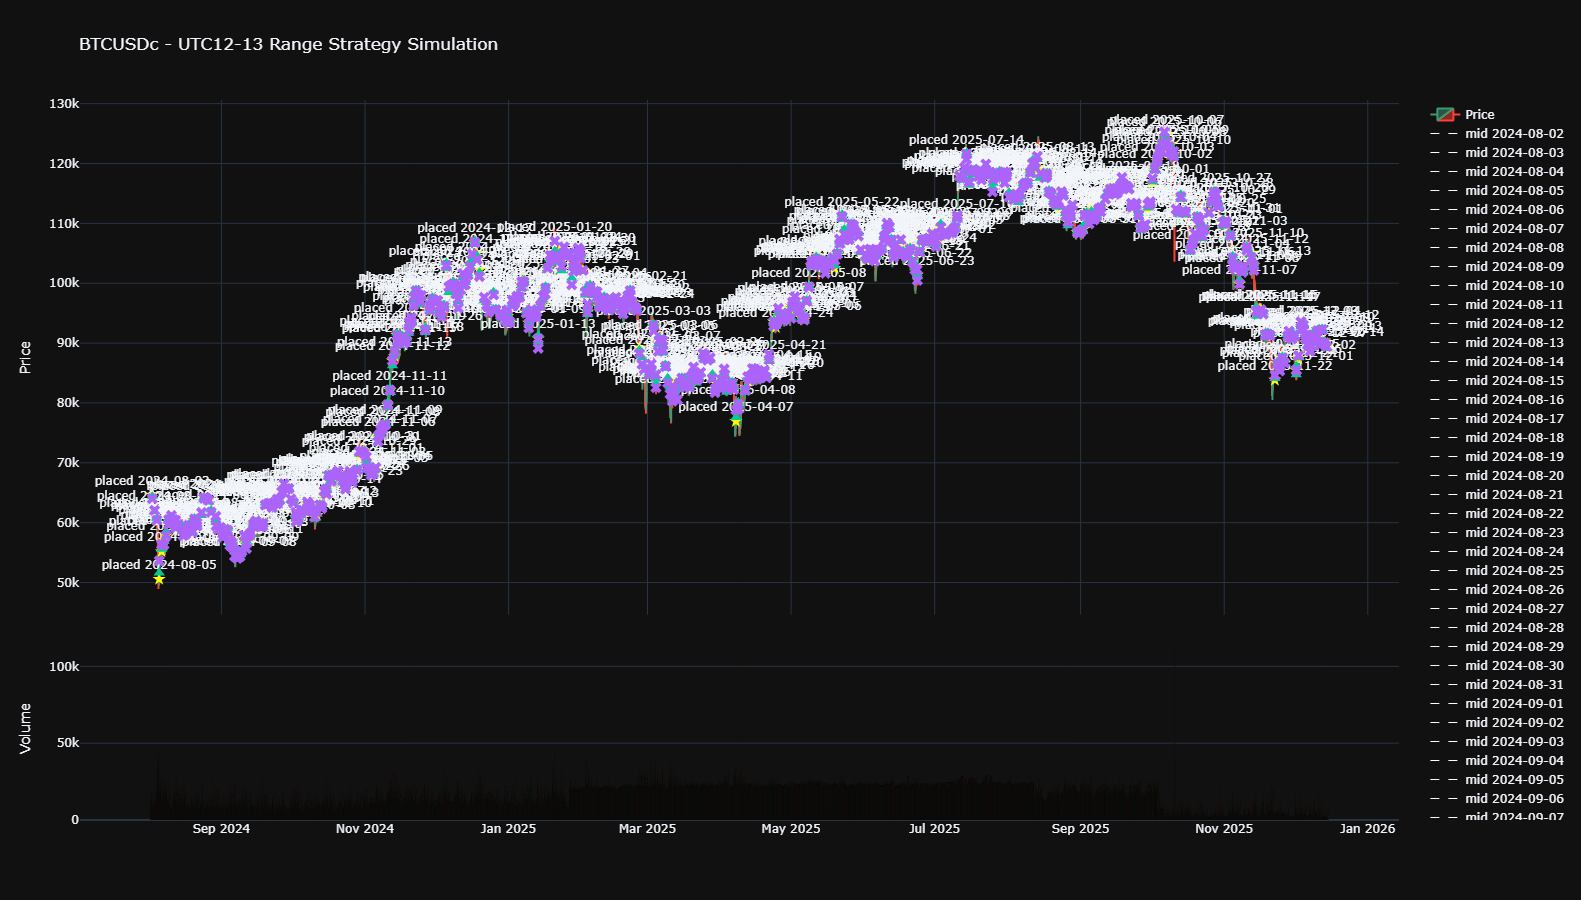

In [6]:
# -----------------------------
# STRATEGY: UTC 12→13 RANGE + REVISIT -> PLACE BOTH STOPS (Buy @High, Sell @Low)
# Backtest simulation (no live order placement)
# -----------------------------

import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "BTCUSDc"           # change to your broker symbol
timeframe = mt.TIMEFRAME_H1  # M30 data
num_candles = 12000           # load enough history to get many days
lookback = 500                 # keep existing swing logic (unused for strategy here)
risk_multiplier = 2.0        # TP = 2R

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA (optional)
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]  # 12:00 - 12:59 UTC
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. STRATEGY SIMULATION WITH 1% RISK MANAGEMENT + 20% COMMISSION
# -----------------------------
trades = []  # list of dicts {entry_time, side, entry_price, sl, tp, exit_time, exit_price, pnl, r, position_size}
verbose = False

equity = 2000  # starting capital
risk_per_trade_pct = 0.05  # 1% risk per trade
commission_pct = 0.20       # 20% commission on profit/loss

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
    try:
        start_loc = df.index.get_loc(session_end_naive)
    except KeyError:
        future_idx = df.index.searchsorted(session_end_naive)
        start_loc = future_idx

    # Monitor candles **only for the same day**
    monitor_slice = df.iloc[start_loc+1:]
    monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
    if monitor_slice.empty:
        continue

    mid = box['mid']
    box_high = box['high']
    box_low = box['low']

    placed_pending = False
    my_pending = []

    for idx, row in monitor_slice.iterrows():
        # Check for mid revisit to place pending orders
        if not placed_pending:
            if (row['Low'] <= mid <= row['High']):
                placed_pending = True

                # Define buystop at box_high
                buy_entry = box_high
                buy_sl = mid
                buy_r = abs(buy_entry - buy_sl)
                buy_tp = buy_entry + risk_multiplier * buy_r
                buy_position_size = (equity * risk_per_trade_pct) / buy_r  # position size to risk 1%

                # Define sellstop at box_low
                sell_entry = box_low
                sell_sl = mid
                sell_r = abs(sell_entry - sell_sl)
                sell_tp = sell_entry - risk_multiplier * sell_r
                sell_position_size = (equity * risk_per_trade_pct) / sell_r

                my_pending = [
                    {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'position_size':buy_position_size,
                     'placed_at': idx, 'activated': False},
                    {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'position_size':sell_position_size,
                     'placed_at': idx,'activated': False}
                ]
                if verbose:
                    print(f"[{box['date']}] Mid revisit at {idx} -> placed pending buy @ {buy_entry} and sell @ {sell_entry}")
                continue
            else:
                continue

        # Check executions for pending orders
        for po in my_pending:
            if po['activated']:
                continue
            if po['side'] == 'buystop':
                if row['High'] >= po['entry']:
                    entry_time = idx
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    pos_idx = monitor_slice.index.get_loc(idx)
                    exit_price = None
                    exit_time = None
                    pnl = None
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['High'] >= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            pnl = (exit_price - entry_price) * po['position_size']
                            break
                        if r2['Low'] <= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            pnl = (exit_price - entry_price) * po['position_size']
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']
                        pnl = (exit_price - entry_price) * po['position_size']

                    # Apply commission
                    pnl *= (1 - commission_pct)

                    trades.append({
                        'box_date': box['date'],
                        'entry_time': entry_time,
                        'side': 'long',
                        'entry_price': entry_price,
                        'sl': sl,
                        'tp': tp,
                        'exit_time': exit_time,
                        'exit_price': exit_price,
                        'pnl': pnl,
                        'r': (exit_price - entry_price) / (entry_price - sl) if (entry_price - sl) != 0 else np.nan,
                        'position_size': po['position_size'],
                        'triggered_by': 'buystop'
                    })
                    po['activated'] = True
                    equity += pnl  # update equity after trade

            elif po['side'] == 'sellstop':
                if row['Low'] <= po['entry']:
                    entry_time = idx
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    pos_idx = monitor_slice.index.get_loc(idx)
                    exit_price = None
                    exit_time = None
                    pnl = None
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['Low'] <= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            pnl = (entry_price - exit_price) * po['position_size']
                            break
                        if r2['High'] >= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            pnl = (entry_price - exit_price) * po['position_size']
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']
                        pnl = (entry_price - exit_price) * po['position_size']

                    # Apply commission
                    pnl *= (1 - commission_pct)

                    trades.append({
                        'box_date': box['date'],
                        'entry_time': entry_time,
                        'side': 'short',
                        'entry_price': entry_price,
                        'sl': sl,
                        'tp': tp,
                        'exit_time': exit_time,
                        'exit_price': exit_price,
                        'pnl': pnl,
                        'r': (entry_price - exit_price) / (sl - entry_price) if (sl - entry_price) != 0 else np.nan,
                        'position_size': po['position_size'],
                        'triggered_by': 'sellstop'
                    })
                    po['activated'] = True
                    equity += pnl  # update equity after trade

        if all(po['activated'] for po in my_pending) and len(my_pending) > 0:
            break

    # Reset per-box pending orders to avoid carryover
    my_pending = []
    placed_pending = False


# -----------------------------
# 5. REPORT RESULTS
# -----------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed in this backtest (no mid revisits or triggers).")
else:
    total_pnl = trades_df['pnl'].sum()
    wins = trades_df[trades_df['pnl'] > 0].shape[0]
    losses = trades_df[trades_df['pnl'] <= 0].shape[0]
    avg_r = trades_df['r'].mean()
    print(f"Trades: {len(trades_df)}, Wins: {wins}, Losses: {losses}, Total PnL (price units): {total_pnl:.2f}, Avg R: {avg_r:.2f}")

print(pd.DataFrame(trades))

# -----------------------------
# 6. PLOT (candles + boxes + pending/entries/exits)
# -----------------------------
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.25], vertical_spacing=0.03)

fig.add_trace(go.Candlestick(
    x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Price'
), row=1, col=1)

for b in session_boxes:
    fig.add_shape(
        type='rect',
        x0=b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
        x1=b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end'],
        y0=b['low'], y1=b['high'],
        line=dict(color='cyan', width=1),
        fillcolor='rgba(0,255,255,0.10)',
        layer='below'
    )
    fig.add_trace(go.Scatter(
        x=[b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
           b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end']],
        y=[b['mid'], b['mid']],
        mode='lines',
        line=dict(color='white', width=1, dash='dash'),
        name=f"mid {b['date']}"
    ), row=1, col=1)

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'],'tzinfo') else box['end']
    future_slice = df.loc[session_end_naive + timedelta(minutes=1):]
    future_slice = future_slice[future_slice.index.date == box['date']]
    revisit_index = None
    for idx, r in future_slice.iterrows():
        if r['Low'] <= box['mid'] <= r['High']:
            revisit_index = idx
            break
    if revisit_index is not None:
        fig.add_trace(go.Scatter(
            x=[revisit_index],
            y=[box['mid']],
            mode='markers+text',
            marker=dict(symbol='star', size=10, color='yellow'),
            text=[f"placed {box['date']}"],
            textposition='top center',
            showlegend=False
        ), row=1, col=1)

if not trades_df.empty:
    fig.add_trace(go.Scatter(
        x=trades_df['entry_time'],
        y=trades_df['entry_price'],
        mode='markers',
        marker=dict(size=10, symbol='triangle-up'),
        name='Entry'
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=trades_df['exit_time'],
        y=trades_df['exit_price'],
        mode='markers',
        marker=dict(size=10, symbol='x'),
        name='Exit'
    ), row=1, col=1)

colors = ['green' if d>0 else ('red' if d<0 else 'gray') for d in df['Delta']]
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], marker_color=colors, name='Volume'), row=2, col=1)

fig.update_layout(template='plotly_dark', height=900, title=f"{symbol} - UTC12-13 Range Strategy Simulation")
fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)
fig.update_xaxes(rangeslider_visible=False)

#fig.show()

# -----------------------------
# END
# -----------------------------


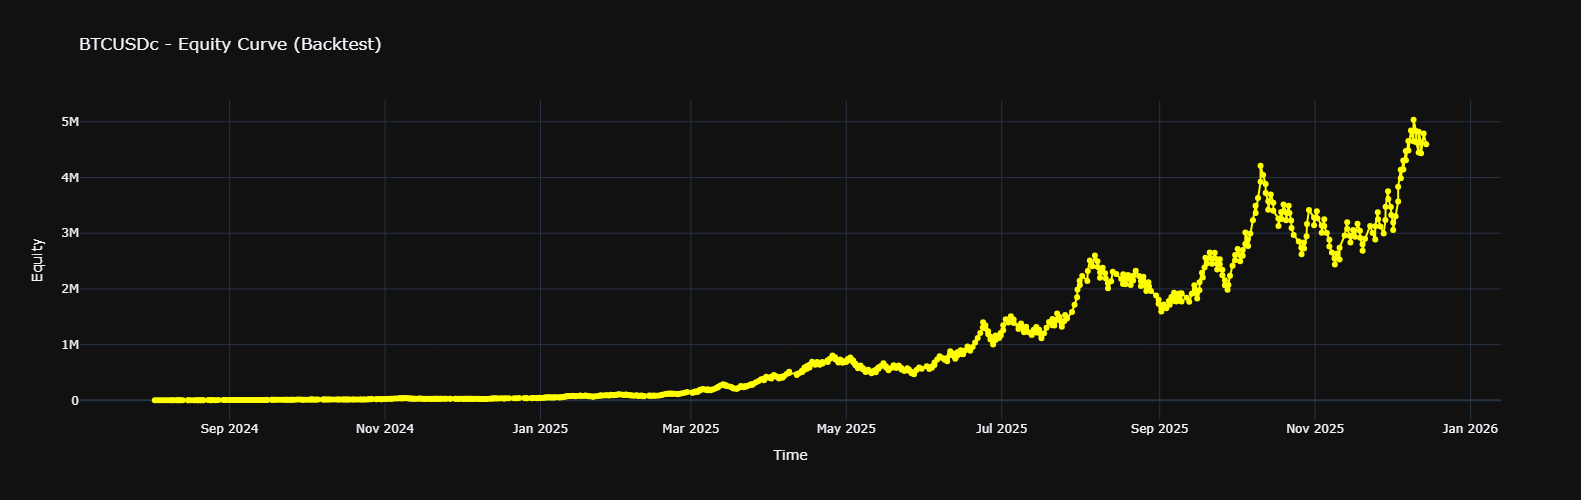

In [7]:
# -----------------------------
# 7. PLOT EQUITY CURVE
# -----------------------------
if trades_df.empty:
    print("No trades executed. Equity curve cannot be plotted.")
else:
    # Create equity curve
    trades_df = pd.DataFrame(trades)
    trades_df.sort_values('exit_time', inplace=True)
    equity_curve = []
    current_equity = 2000  # starting capital
    for idx, trade in trades_df.iterrows():
        current_equity += trade['pnl']
        equity_curve.append({'time': trade['exit_time'], 'equity': current_equity})

    equity_df = pd.DataFrame(equity_curve)
    equity_df.set_index('time', inplace=True)

    # Plot equity curve
    fig_eq = go.Figure()
    fig_eq.add_trace(go.Scatter(
        x=equity_df.index,
        y=equity_df['equity'],
        mode='lines+markers',
        line=dict(color='yellow', width=2),
        name='Equity Curve'
    ))
    fig_eq.update_layout(
        template='plotly_dark',
        title=f"{symbol} - Equity Curve (Backtest)",
        xaxis_title='Time',
        yaxis_title='Equity',
        height=500
    )
    fig_eq.show()
